New Tributes Extraction
===

This script processes the json tributes in the new (2019) dataset to a feather file.


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import re
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
import sqlite3
from nltk import word_tokenize
from html.parser import HTMLParser
from tqdm import tqdm
import random
import pickle
import json

from datetime import datetime
from pprint import pprint

import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib
import pylab as pl
from IPython.core.display import display, HTML

In [3]:
from pathlib import Path
git_root_dir = !git rev-parse --show-toplevel
git_root_dir = Path(git_root_dir[0].strip())
git_root_dir

PosixPath('/panfs/roc/groups/3/srivbane/levon003/repos/sna-social-support')

In [4]:
import sys
caringbridge_core_path = "/home/srivbane/levon003/repos/caringbridge_core"
sys.path.append(caringbridge_core_path)

In [5]:
import cbcore.data.paths as paths
import cbcore.data.dates as dates

In [6]:
raw_data_dir = paths.raw_data_2019_filepath

In [7]:
working_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/csv_data"
assert os.path.exists(working_dir)

In [21]:
def extract_long(json_value):
    if type(json_value) == int:
        return json_value
    elif type(json_value) == str:
        return int(json_value)
    elif type(json_value) == dict:
        return int(json_value['$numberLong'])
    elif json_value == 0.0:  # special case for userId, which I assume is essentially "missing/unknown" or user deleted?
        return ""
    elif type(json_value) == float:
        return int(json_value)
    else:
        raise ValueError(f"Type '{type(json_value)}' not implemented: {str(json_value)}")
        
        
def get_amount(json_value):
    return float(json_value)

In [22]:
tributes_filepath = os.path.join(raw_data_dir, 'tribute_scrubbed.json')
tributes = []
with open(tributes_filepath, encoding='utf-8') as infile:
    for line in tqdm(infile, total=1023572):
        tribute = json.loads(line)
        site_id = extract_long(tribute['siteId'])
        user_id = extract_long(tribute['userId']) if 'userId' in tribute else ""
        created_at = dates.get_date_from_json_value(tribute['createdAt'])
        updated_at = dates.get_date_from_json_value(tribute['updatedAt'])

        amount = get_amount(tribute['amount']) if 'amount' in tribute else None

        tribute_id = tribute['_id']['$oid']
        body = tribute['body'] if 'body' in tribute else ""
        signature = tribute['signature'] if 'signature' in tribute else ""
        charityWebId = tribute['charityWebId'] if 'charityWebId' in tribute else ""
        isAnonymous = tribute['isAnonymous'] if 'isAnonymous' in tribute else ""
        isDisplayed = tribute['isDisplayed'] if 'isDisplayed' in tribute else ""
        isDeleted = tribute['isDeleted'] if 'isDeleted' in tribute else ""
        isRecurring = tribute['isRecurring'] if 'isRecurring' in tribute else ""
        optIn = tribute['optIn'] if 'optIn' in tribute else ""
        providerId = tribute['providerId'] if 'providerId' in tribute else ""
        provider = tribute['provider'] if 'provider' in tribute else ""
        
        t = {
            "site_id": site_id,
            "user_id": user_id,
            "created_at": created_at,
            "updated_at": updated_at,
            "amount": amount,
            "tribute_id": tribute_id,
            "body": body,
            "signature": signature,
            "charityWebId": charityWebId,
            "isAnonymous": isAnonymous,
            "isDisplayed": isDisplayed,
            "isDeleted": isDeleted,
            "isRecurring": isRecurring,
            "optIn": optIn,
            "providerId": providerId,
            "provider": provider
        }
        tributes.append(t)
len(tributes)

100%|██████████| 1023572/1023572 [01:05<00:00, 15622.50it/s]


1023572

In [23]:
# fixed a degenerate datetime situation
datetime.strptime('2013-06-28T06:32:38.471Z', "%Y-%m-%dT%H:%M:%S.%fZ")

datetime.datetime(2013, 6, 28, 6, 32, 38, 471000)

In [ ]:
df = pd.DataFrame(tributes)
df.head()

### Tributes dataframe analysis

In [25]:
# Vast majority don't provide an amount!
len(df[df.amount.isnull()]) / len(df)

0.9265161610516895

Number of months captured: 98.773 (using 99 bins)


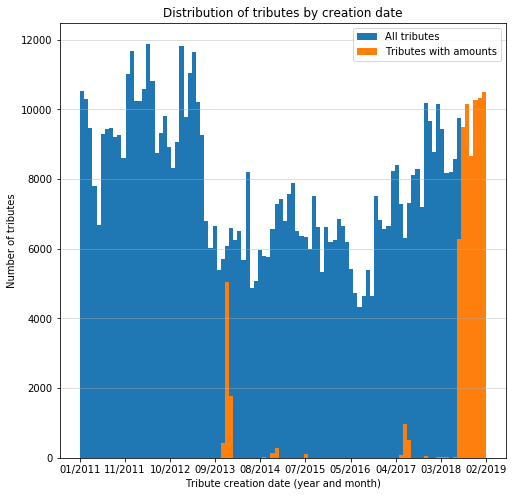

In [26]:
# Plot the distribution of tributes by date
title = "Distribution of tributes by creation date"
fig, ax = pl.subplots(num=title, figsize=(8,8))

start = 1293840000000  # 2011
#end = 1451606400000  # 2016
#start = np.min(df.created_at)
end = np.max(df.created_at)
# we want the binsize to be equal to one month (30 days)
# so, how many months are between the start and end date?
num_months = (end - start) / 1000 / 60 / 60 / 24 / 30
print(f"Number of months captured: {num_months:.3f} (using {int(np.round(num_months))} bins)")
bins = np.linspace(start, end, num=int(np.round(num_months)))

sub_df = df[(df.created_at >= start)&(df.created_at <= end)]


total_bin_counts, bins, _ = plt.hist(sub_df.created_at, 
                                     bins=bins, range=(0,1), label="All tributes")
amount_bin_counts, bins, _ = plt.hist(sub_df[~sub_df.amount.isnull()].created_at, 
                                       bins=bins, range=(0,1), label="Tributes with amounts")

ax = plt.gca()
ax.set_xticks(np.linspace(start, end, num=10))
ax.set_xticklabels([datetime.utcfromtimestamp(x / 1000).strftime('%m/%Y') for x in  ax.get_xticks()])

ax.set_title(title)
ax.set_xlabel("Tribute creation date (year and month)")
ax.set_ylabel("Number of tributes")

ax.legend()

ax.grid(axis="y", alpha=0.5)
plt.show()

In [27]:
last_nonamount_tribute = np.max(df[df.amount.isnull()].created_at)
datetime.utcfromtimestamp(last_nonamount_tribute / 1000).strftime('%Y-%m-%dT%H:%M:%S.%fZ')

'2018-07-26T05:00:00.000000Z'

In [28]:
# most recent tribute in the dataset?
datetime.utcfromtimestamp(np.max(df.created_at) / 1000).strftime('%Y-%m-%dT%H:%M:%S.%fZ')

'2019-02-11T04:53:57.000000Z'

In [61]:
delta = datetime.utcfromtimestamp(np.max(df.created_at) / 1000) - datetime.utcfromtimestamp(last_nonamount_tribute / 1000)
str(delta), f"{delta.total_seconds() / 60 / 60:.1f} hours"

('199 days, 23:53:57', '4799.9 hours')

Number of days captured in range: 199.996 (using 200 bins)
Showing 64799 daily tributes with amount info.
17739 sites represented in sample.


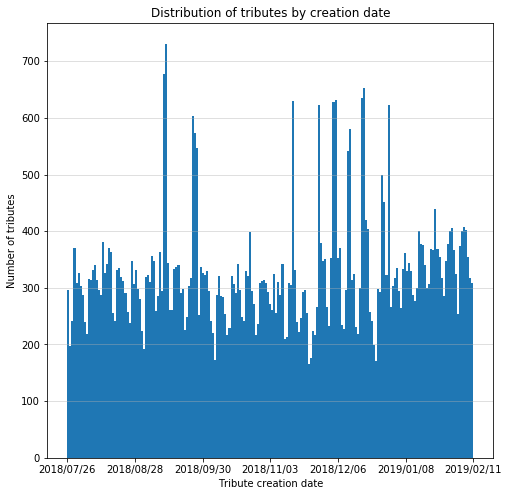

In [62]:
# Plot the distribution of tributes by date
title = "Distribution of tributes by creation date"
fig, ax = pl.subplots(num=title, figsize=(8,8))

start = last_nonamount_tribute  # all days since the last amount wasn't present
end = np.max(df.created_at)
# we want the binsize to be equal to one day
num_days = (end - start) / 1000 / 60 / 60 / 24
print(f"Number of days captured in range: {num_days:.3f} (using {int(np.round(num_days))} bins)")
bins = np.linspace(start, end, num=int(np.round(num_days)))

sub_df = df[(df.created_at > start)&(df.created_at <= end)]
print(f"Showing {len(sub_df)} daily tributes with amount info.")
print(f"{len(set(sub_df.site_id))} sites represented in sample.")

total_bin_counts, bins, _ = plt.hist(sub_df.created_at, 
                                     bins=bins, range=(0,1), label="All tributes")
#amount_bin_counts, bins, _ = plt.hist(sub_df[~sub_df.amount.isnull()].created_at, 
#                                       bins=bins, range=(0,1), label="Tributes with amounts")

ax = plt.gca()
ax.set_xticks(np.linspace(start, end, num=7))
ax.set_xticklabels([datetime.utcfromtimestamp(x / 1000).strftime('%Y/%m/%d') for x in  ax.get_xticks()])

ax.set_title(title)
ax.set_xlabel("Tribute creation date")
ax.set_ylabel("Number of tributes")

ax.grid(axis="y", alpha=0.5)
plt.show()

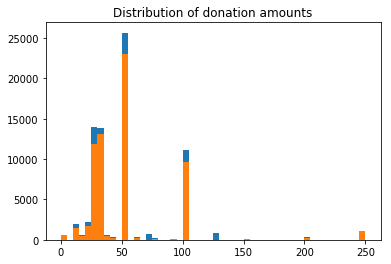

In [65]:
plt.hist(df[~df.amount.isnull()].amount, log=False, bins=50, range=(0,250))
plt.hist(sub_df[~sub_df.amount.isnull()].amount, log=False, bins=50, range=(0,250))
plt.title("Distribution of donation amounts")
plt.show()